# Семинар 3 "Матричное разложение"

**План Семинара:**
    
    - ALS from scratch
    
    - MF w/o features based on RecTools implementations
    
    - Advantages of ANN

# iALS from scratch

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns

$$
\begin{aligned}
&\frac{\partial L}{\partial p_u}=0 \Rightarrow p_u=\left(Q^TC_u Q+\lambda I\right)^{-1} Q^T C_u \phi_u \\
&\frac{\partial L}{\partial q_i}=0 \Rightarrow q_i=\left(P^TC_i P+\lambda I\right)^{-1} P^T C_i \phi_i
\end{aligned}
$$

$$
\begin{aligned}
&\frac{\partial L}{\partial p_u}=0 \Rightarrow p_u=\left(Q^T Q+Q^T\left(C_u-I\right) Q+\lambda I\right)^{-1} Q^T C_u \phi_u \\
&\frac{\partial L}{\partial q_i}=0 \Rightarrow q_i=\left(P^T P+P^T\left(C_i-I\right) P+\lambda I\right)^{-1} P^T C_i \phi_i
\end{aligned}
$$

$$ L\left(p_u, q_i, r_{u i}\right)=\sum_{u, i \in R} c_{u i} \cdot\left(\phi_{u i}-\langle p_u, q_i \rangle\right)^2=\sum_{u, i \in R}\left(1+\alpha r_{u i}\right)\left(\phi_{u i}-\langle p_u, q_i \rangle\right)^2 $$

Для более легкого понимания: [A gentle introduction to Alternating Least Squares](https://sophwats.github.io/2018-04-05-gentle-als.html)

In [15]:
class ImplicitALS:

    def __init__(self, R, k=3, a=40, l2=10):
        self.l2 = l2
        self.k = k
        self.a = a
        self.m, self.n = R.shape

        # Инициализируем эмбеддинги пользователей (P) и товаров (Q)
        self.P = np.random.rand(self.m, self.k)
        self.Q = np.random.rand(self.n, self.k)

        self.phi = np.where(R > 0, 1, 0)
        self.C = 1 + a * R

        self.loss = []

    def train(self, n_step=10):
        l2_reg = self.l2 * np.identity(self.k)
        for _ in range(n_step):

            # fix P, update Q
            PtP = self.P.T.dot(self.P)
            for i in range(self.n):
                Ci =  np.diag(self.C[:, i])
                Wi =  PtP + self.P.T.dot(Ci - np.identity(self.m)).dot(self.P) + l2_reg
                self.Q[i] = np.linalg.inv(Wi).dot(self.P.T).dot(Ci).dot(self.phi[:, i])

            # fix Q, update P
            QtQ = self.Q.T.dot(self.Q)
            for u in range(self.m):
                Cu = np.diag(self.C[u, :])
                Wu = QtQ + self.Q.T.dot(Cu - np.identity(self.n)).dot(self.Q) + l2_reg
                self.P[u] = np.linalg.inv(Wu).dot(self.Q.T).dot(Cu).dot(self.phi[u, :])
                
            # Вычисляем LOSS
            loss = (self.C * (self.phi - self.P.dot(self.Q.T)) ** 2).sum()
            l2_all = (self.P ** 2).sum() + (self.Q ** 2).sum()
            loss_with_l2_reg = loss + self.l2 * l2_all
            self.loss.append(loss_with_l2_reg)

    def predict(self, u, i):
        return self.P[u].dot(self.Q[i])


In [16]:
np.random.seed(32)

In [17]:
stars = np.arange(6)
p = np.array([10, 1, 1, 1, 1, 1])
m = 5  # Кол-во пользователей
n = 10  # Кол-во товаров

ratings = np.random.choice(stars, size=m*n, p=p / p.sum()).reshape((m, n))

ratings

array([[3, 0, 0, 5, 2, 3, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 2],
       [4, 0, 4, 0, 0, 5, 0, 1, 0, 3],
       [0, 0, 0, 0, 0, 0, 1, 2, 1, 0],
       [0, 0, 0, 0, 5, 0, 0, 1, 3, 0]])

In [18]:
ratings.shape

(5, 10)

In [19]:
als = ImplicitALS(R=ratings, k=16)

In [20]:
als.train(n_step=50)

In [21]:
als.loss[:5]

[216.66070569213,
 186.93856812837126,
 172.52084974243346,
 163.84104023884765,
 158.1285606162813]

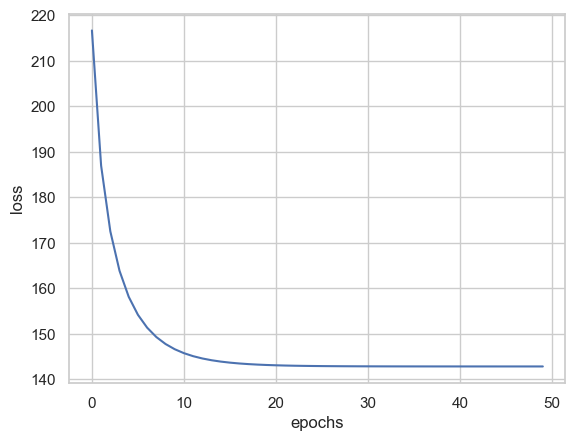

In [22]:
ax = sns.lineplot(als.loss)
ax.set_xlabel("epochs")
ax.set_ylabel("loss");

In [23]:
assert als.P.shape[0] == ratings.shape[0]
assert als.Q.shape[0] == ratings.shape[1]
assert als.P.shape[1] == als.Q.shape[1]

In [24]:
# Предскажем для всех
pred_ratings = np.matmul(als.P, als.Q.T).round(2)
pred_ratings

array([[ 0.97,  0.  ,  0.79,  0.96,  0.96,  0.97,  0.39,  0.99,  0.62,
         0.81],
       [ 0.72,  0.  ,  0.71,  0.57,  0.25,  0.86, -0.09,  0.4 , -0.06,
         0.9 ],
       [ 0.97,  0.  ,  0.95,  0.77,  0.66,  1.  ,  0.33,  0.92,  0.4 ,
         0.99],
       [ 0.4 ,  0.  ,  0.33,  0.39,  0.83,  0.16,  0.81,  0.95,  0.93,
         0.01],
       [ 0.49,  0.  ,  0.33,  0.57,  0.97,  0.29,  0.74,  0.96,  0.95,
         0.07]])

In [25]:
ratings

array([[3, 0, 0, 5, 2, 3, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 2],
       [4, 0, 4, 0, 0, 5, 0, 1, 0, 3],
       [0, 0, 0, 0, 0, 0, 1, 2, 1, 0],
       [0, 0, 0, 0, 5, 0, 0, 1, 3, 0]])

In [26]:
for row_idx in range(ratings.shape[0]):
    print("Original:")
    print(ratings[row_idx, :])
    print("Predicted:")
    print(pred_ratings[row_idx, :])
    print("-----------")

Original:
[3 0 0 5 2 3 0 4 0 0]
Predicted:
[0.97 0.   0.79 0.96 0.96 0.97 0.39 0.99 0.62 0.81]
-----------
Original:
[0 0 0 0 0 1 0 0 0 2]
Predicted:
[ 0.72  0.    0.71  0.57  0.25  0.86 -0.09  0.4  -0.06  0.9 ]
-----------
Original:
[4 0 4 0 0 5 0 1 0 3]
Predicted:
[0.97 0.   0.95 0.77 0.66 1.   0.33 0.92 0.4  0.99]
-----------
Original:
[0 0 0 0 0 0 1 2 1 0]
Predicted:
[0.4  0.   0.33 0.39 0.83 0.16 0.81 0.95 0.93 0.01]
-----------
Original:
[0 0 0 0 5 0 0 1 3 0]
Predicted:
[0.49 0.   0.33 0.57 0.97 0.29 0.74 0.96 0.95 0.07]
-----------


# PureSVD and ALS from Rectools

In [27]:
# pip install rectools

In [28]:
# pip install implicit

In [29]:
import os
import requests
import threadpoolctl
import warnings
import time
import typing as tp
from tqdm import tqdm
from pathlib import Path

import pandas as pd
import plotly.express as px
import numpy as np
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
import matplotlib.pyplot as plt
import seaborn as sns

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import Precision, Recall, MAP, MeanInvUserFreq, NDCG, Serendipity, calc_metrics
from rectools.models import PopularModel, RandomModel, PureSVDModel, ImplicitALSWrapperModel, ImplicitBPRWrapperModel

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# For implicit ALS
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# threadpoolctl.threadpool_limits(1, "blas");

## Подготовим данные

In [17]:
# !wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_en.zip -O data_en.zip
# !unzip -o data_en.zip
# !rm data_en.zip

In [30]:
BASE_PATH = Path("./data_en")

In [31]:
interactions = pd.read_csv(BASE_PATH / "interactions.csv")
users = pd.read_csv(BASE_PATH / "users_en.csv")
items = pd.read_csv(BASE_PATH / "items_en.csv")

In [32]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [33]:
# переименовываем поля в понятные для RecTools

interactions = interactions.rename(
    columns={
        'watched_pct': Columns.Weight,
        'last_watch_dt': Columns.Datetime
    }
)

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

# Interactions

In [34]:
interactions.head()

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [35]:
interactions[Columns.Weight].fillna(0, inplace = True)

In [36]:
interactions[interactions[Columns.Weight].isna()]

,user_id,item_id,datetime,total_dur,weight


In [37]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   user_id    int64         
 1   item_id    int64         
 2   datetime   datetime64[ns]
 3   total_dur  int64         
 4   weight     float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


In [38]:
print(f"Interactions shape {interactions.shape}")
print(f"Unique users in interactions: {interactions['user_id'].nunique():_}")
print(f"Unique items in interactions: {interactions['item_id'].nunique():_}")
print(f"min date in interactions: {interactions['datetime'].min()}")
print(f"max date in interactions: {interactions['datetime'].max()}")

Interactions shape (5476251, 5)
Unique users in interactions: 962_179
Unique items in interactions: 15_706
min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


# Users

In [39]:
users.head()

,Unnamed: 0,user_id,age,income,sex,kids_flg
0,0,973171,age_25_34,income_60_90,M,1
1,1,962099,age_18_24,income_20_40,M,0
2,2,1047345,age_45_54,income_40_60,F,0
3,3,721985,age_45_54,income_20_40,F,0
4,4,704055,age_35_44,income_60_90,F,0


In [40]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  840197 non-null  int64 
 1   user_id     840197 non-null  int64 
 2   age         826102 non-null  object
 3   income      825421 non-null  object
 4   sex         826366 non-null  object
 5   kids_flg    840197 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 38.5+ MB


In [41]:
print(f"Users shape {users.shape}")
print(f"Unique users: {users['user_id'].nunique():_}")

Users shape (840197, 6)
Unique users: 840_197


# Items

In [42]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15963 non-null  int64  
 1   item_id                15963 non-null  int64  
 2   content_type           15963 non-null  object 
 3   title                  15961 non-null  object 
 4   title_orig             11218 non-null  object 
 5   release_year           15865 non-null  float64
 6   genres                 15963 non-null  object 
 7   countries              15963 non-null  object 
 8   for_kids               566 non-null    float64
 9   age_rating             15961 non-null  float64
 10  studios                1065 non-null   object 
 11  description            15963 non-null  object 
 12  keywords               15534 non-null  object 
 13  actors_translated      13344 non-null  object 
 14  actors_transliterated  13344 non-null  object 
 15  di

In [44]:
items.head()

,Unnamed: 0,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,description,keywords,actors_translated,actors_transliterated,directors_translated,transliterated
0,0,10711,film,Talk to her,Hable con ella,2002.0,"drama, foreign, detective, melodrama",Spain,NaN,16.0,NaN,"Marco, a journalist, interviews the famous Tor...","Talk, her, 2002, Spain, friends, love, strong,...","Adolfo Fernández, Ana Fernández, Dario Grandin...","Adol'fo Fernandes, Ana Fernandes, Dario Grandi...",Pedro Almodovar,Pedro Al'modovar
1,1,2508,film,Naked Peppers,Search Party,2014.0,"foreign, adventure, comedy",USA,NaN,16.0,NaN,The main character has learned not to invite h...,"Naked, Peppers, 2014, USA, friends, weddings, ...","Adam Palley, Brian Huskey, JB Smoove, Jason Ma...","Adam Palli, Brajan Haski, Dzh.B. Smuv, Dzhejso...",Scott Armstrong,Skot Armstrong
2,2,10716,film,Tactical force,Tactical Force,2011.0,"crime, foreign, thrillers, action, comedy",Canada,NaN,16.0,NaN,"Professional wrestler Steve Austin (""All or No...","Tactical, Force, 2011, Canada, bandits, gangst...","Adrian Holmes, Darren Shalavi, Jerry Wasserman...","Adrian Holms, Darren Shalavi, Dzherri Vasserma...",Adam P. Caltraro,Adam P. Kaltraro
3,3,7868,film,45 years old,45 Years,2015.0,"drama, foreign, melodrama",UK,NaN,16.0,NaN,"Charlotte Rampling, Tom Courtney, Geraldine Ja...","45, years, 2015, United Kingdom, marriage, lif...","Alexandra Riddleston-Barrett, Geraldine James,...","Aleksandra Riddlston-Barrett, Dzheral'din Dzhe...",By Andrew Hay,Endrju Hej
4,4,16268,film,Everything Solves in a Moment,NaN,1978.0,"drama, sport, soviet, melodrama",USSR,NaN,12.0,Lenfilm,The circle of her mentors and the most loyal f...,"Everything that decides, moment, 1978, USSR, s...","Aleksandr Abdulov, Aleksandr Demyanenko, Alexe...","Aleksandr Abdulov, Aleksandr Dem'janenko, Alek...",Victor Sadovsky,Viktor Sadovskij


In [45]:
print(f"Items dataframe shape {items.shape}")
print(f"Unique item_id: {items['item_id'].nunique():_}")

Items dataframe shape (15963, 17)
Unique item_id: 15_963


# Train test split

In [46]:
min_date = interactions['datetime'].min()
max_date = interactions['datetime'].max()

print(f"min date in interactions: {min_date}")
print(f"max date in interactions: {max_date}")

min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


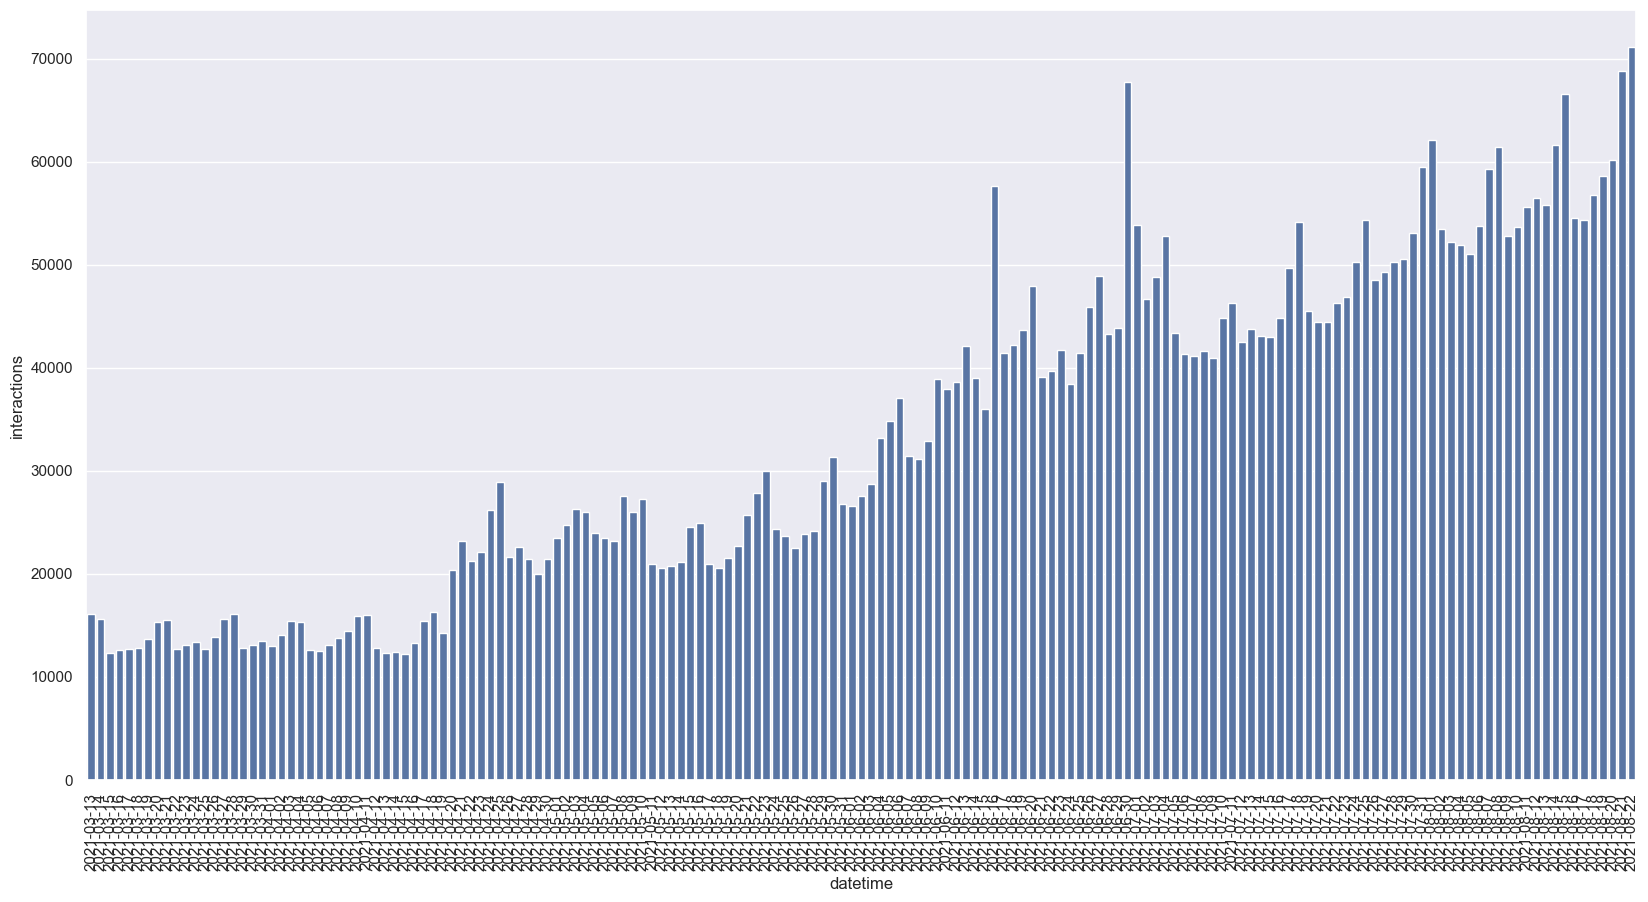

In [47]:
daily_iters = interactions.groupby(Columns.Datetime)[Columns.Datetime].agg("count")
daily_iters.name = "interactions"

sns.set_theme(rc={'figure.figsize':(20, 10)})
ax = sns.barplot(daily_iters)
plt.xticks(rotation=90);

Из графика распределения интеракций по дням можно заметить **недельные тренды** -> **на валидацию и тест можем брать по одной неделе**

In [48]:
max_date = interactions['datetime'].max()

train = interactions[(interactions['datetime'] < max_date - pd.Timedelta(days=7)) &
                     (interactions['datetime'] > max_date - pd.Timedelta(days=37))]
test = interactions[(interactions['datetime'] >= max_date - pd.Timedelta(days=7))]

# оставляем только горячих пользователей в тесте
test_hot = test[test['user_id'].isin(train['user_id'].unique())]

print(f"train: {train.shape}")
print(f"test hot: {test_hot.shape}")

train: (1528877, 5)
test hot: (312789, 5)


# Models w/o features

Создаем rectools.Dataset без фичей:

In [49]:
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=None,
)

In [50]:
K_RECOS = 10
RANDOM_STATE = 32
NUM_THREADS = 16
N_FACTORS = [4, 16, 32]

### PureSVD: Реализация RecTools <a class="anchor" id="svd_impl"></a>
RecTools реализует усеченную версию SVD. Для этого необходимо извлечь k факторов, то есть взять k наибольших сингулярных значений из $\Sigma$ и k первых столбцов из U и V.

Латентные представления пользователей и предметов следующие:

1. факторы пользователей $X$ = $U$
   
2. факторы предметов $Y$ = $\Sigma \cdot V^{T}$


RecTools использует scipy.sparse.linalg.svds для вычисления декомпозиции.

### Формирование Рекомендаций <a class="anchor" id="svd_rec"></a>
1. Рекомендация для пары пользователь/вещь выглядит следующим образом: $\hat{r_{ui}} = x_u y_i$

2. Берем k предметов с наибольшим $\hat{r_{ui}}$ для фиксированного пользователя

### Применение модели <a class="anchor" id="svd_apply"></a>
* Указываем размер вложения с помощью PureSVDModel `factors`
* Если мы используем набор данных с характеристиками для `fit` и `recommend`, модель просто пропускает эту информацию.

In [119]:
models = {}

for factors in N_FACTORS:
  models[f"PureSVD_{factors}"] = PureSVDModel(factors=factors)

In [120]:
models

{'PureSVD_4': <rectools.models.pure_svd.PureSVDModel at 0x2c31f4fb0>,
 'PureSVD_16': <rectools.models.pure_svd.PureSVDModel at 0x2d75eae70>,
 'PureSVD_32': <rectools.models.pure_svd.PureSVDModel at 0x2d75ebce0>}

### Применение модели ALS<a class="anchor" id="ials_apply"></a>
* Укажите размер латентных представлений с помощью `factors `
* Укажите коэффициент `regularization`
* Укажите `iterations` для количества эпох обучения модели
* Для вычисления "уверенности" с помощью `AlternatingLeastSquares` используется `alpha`. Веса взаимодействий, которые уже присутствуют в наборе данных, будут умножены на это число. Помните, что $c_{ui} = 1 + \alpha r_{ui}$ и веса взаимодействий рассматриваются как доверие к наблюдениям
* Передайте модель `AlternatingLeastSquares` в обертку
* Используйте набор данных с признаками для `fit` и `recommend`, чтобы добавить обработку признаков в модель.

In [121]:
for factors in N_FACTORS:
  models[f"ALS_factors_{factors}"] = ImplicitALSWrapperModel(
      model=AlternatingLeastSquares(
          factors=factors,
          random_state=RANDOM_STATE,
          num_threads=NUM_THREADS
      )
  )

### BPR: Построение Рекомендаций <a class="anchor" id="bpr_rec"></a>
Рекомендации для всех пользователей получаются из перемножения выученных матриц встраивания $X^T$ и $Y$ (в зависимости от реализации к итоговым оценкам могут быть добавлены пользовательские и/или предметные погрешности). После этого можно извлечь топ-к предметов.

### Реализация RecTools <a class="anchor" id="bpr_impl"></a>
RecTools предоставляет обертку для `имплицитной` `BayesianPersonalizedRanking` модели. Реализация `имплицитной` модели имеет несколько важных особенностей:
- **Модель игнорирует веса взаимодействий** и рассматривает все взаимодействия в наборе данных одинаково
- Фактор `регуляризации` является общим для факторов пользователя и продукта
- Модель обучается с помощью SGD
- Применяется **основанная на популярности** отрицательная выборка


In [122]:
for factors in N_FACTORS:
  models[f"BPR_factors_{factors}"] = ImplicitBPRWrapperModel(
      model=BayesianPersonalizedRanking(
          factors=factors,
          random_state=RANDOM_STATE,
          num_threads=NUM_THREADS
      )
  )

### Logistic Matrix Factorization: Построение Рекомендаций <a class="anchor" id="bpr_rec"></a>

In [123]:
ui_csr = dataset.interactions.get_user_item_matrix()
test_users_lmf = dataset.user_id_map.convert_to_internal(test_hot[Columns.User].unique())

In [124]:
for factors in N_FACTORS:
  models[f"LMF_factors_{factors}"] = LogisticMatrixFactorization(
    factors=factors,
    random_state=RANDOM_STATE,
    num_threads=NUM_THREADS
  )
  models[f"LMF_factors_{factors}"].fit(ui_csr)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [125]:
# Объявляем метрики
metrics_name = {
    "precision": Precision,
    "recall": Recall,
    "ndcg": NDCG,
    "serendipity": Serendipity,
    "novelty": MeanInvUserFreq,
}
K = [3, 5, 10]


metrics = {}
for metric_name, metric in metrics_name.items():
    for k in K:
        metrics[f'{metric_name}@{k}'] = metric(k=k)
metrics

{'precision@3': Precision(k=3, debias_config=None, r_precision=False),
 'precision@5': Precision(k=5, debias_config=None, r_precision=False),
 'precision@10': Precision(k=10, debias_config=None, r_precision=False),
 'recall@3': Recall(k=3, debias_config=None),
 'recall@5': Recall(k=5, debias_config=None),
 'recall@10': Recall(k=10, debias_config=None),
 'ndcg@3': NDCG(k=3, debias_config=None, log_base=2, divide_by_achievable=False),
 'ndcg@5': NDCG(k=5, debias_config=None, log_base=2, divide_by_achievable=False),
 'ndcg@10': NDCG(k=10, debias_config=None, log_base=2, divide_by_achievable=False),
 'serendipity@3': Serendipity(k=3),
 'serendipity@5': Serendipity(k=5),
 'serendipity@10': Serendipity(k=10),
 'novelty@3': MeanInvUserFreq(k=3),
 'novelty@5': MeanInvUserFreq(k=5),
 'novelty@10': MeanInvUserFreq(k=10)}

In [126]:
models

{'PureSVD_4': <rectools.models.pure_svd.PureSVDModel at 0x2c31f4fb0>,
 'PureSVD_16': <rectools.models.pure_svd.PureSVDModel at 0x2d75eae70>,
 'PureSVD_32': <rectools.models.pure_svd.PureSVDModel at 0x2d75ebce0>,
 'ALS_factors_4': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x2c4c14fe0>,
 'ALS_factors_16': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x297722630>,
 'ALS_factors_32': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x297722660>,
 'BPR_factors_4': <rectools.models.implicit_bpr.ImplicitBPRWrapperModel at 0x2c4c902c0>,
 'BPR_factors_16': <rectools.models.implicit_bpr.ImplicitBPRWrapperModel at 0x2c601c320>,
 'BPR_factors_32': <rectools.models.implicit_bpr.ImplicitBPRWrapperModel at 0x297722930>,
 'LMF_factors_4': <implicit.cpu.lmf.LogisticMatrixFactorization at 0x2c30ab380>,
 'LMF_factors_16': <implicit.cpu.lmf.LogisticMatrixFactorization at 0x2c5ed46b0>,
 'LMF_factors_32': <implicit.cpu.lmf.LogisticMatrixFactorization at 0x2c4d49940>}

In [127]:
catalog = train[Columns.Item].unique()

results = []
for model_name, model in tqdm(models.items()):
    if model_name not in {'LMF_factors_4', 'LMF_factors_16', 'LMF_factors_32'}:
      model_quality = {'model': model_name}

      fit_start_time = time.time()

      model.fit(dataset)
      training_time = time.time() - fit_start_time
      print(f"Время обучения модели {model_name}: {training_time:.2f} секунд")
      recos = model.recommend(
          users=test_hot[Columns.User].unique(),
          dataset=dataset,
          k=K_RECOS,
          filter_viewed=True,  # Для чего этот параметр?
      )

      metric_values = calc_metrics(metrics, recos, test_hot, train, catalog=catalog)

      model_quality.update(metric_values)
      results.append(model_quality)

  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

Время обучения модели PureSVD_4: 0.69 секунд


  8%|███████                                                                             | 1/12 [00:17<03:08, 17.13s/it]

Время обучения модели PureSVD_16: 1.72 секунд


 17%|██████████████                                                                      | 2/12 [00:30<02:29, 14.91s/it]

Время обучения модели PureSVD_32: 3.30 секунд


 25%|█████████████████████                                                               | 3/12 [00:48<02:27, 16.43s/it]

Время обучения модели ALS_factors_4: 4.95 секунд


 33%|████████████████████████████                                                        | 4/12 [01:07<02:18, 17.33s/it]

Время обучения модели ALS_factors_16: 25.01 секунд


 42%|███████████████████████████████████                                                 | 5/12 [01:46<02:55, 25.02s/it]

Время обучения модели ALS_factors_32: 76.97 секунд


 50%|██████████████████████████████████████████                                          | 6/12 [03:19<04:50, 48.41s/it]

Время обучения модели BPR_factors_4: 30.21 секунд


 58%|█████████████████████████████████████████████████                                   | 7/12 [04:04<03:56, 47.23s/it]

Время обучения модели BPR_factors_16: 35.28 секунд


 67%|████████████████████████████████████████████████████████                            | 8/12 [04:54<03:11, 47.91s/it]

Время обучения модели BPR_factors_32: 48.30 секунд


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [05:56<00:00, 29.70s/it]


In [128]:
%%time
reco_LMF = []
for factors in N_FACTORS:
  for user_id in tqdm(test_users_lmf):
      res = models[f"LMF_factors_{factors}"].recommend(user_id, ui_csr[user_id], N=K_RECOS, filter_already_liked_items=True)
      user_ids = [user_id]*K_RECOS
      item_ids = res[0]
      scores = res[1]

      # Создаем записи для каждого элемента рекомендации
      for rank, (user_id, item_id, score) in enumerate(zip(user_ids, item_ids, scores), start=1):
          reco_LMF.append({
              'user_id': user_id,
              'item_id': item_id,
              'score': score,
              'rank': rank
          })
  df_recos = pd.DataFrame(reco_LMF)
  df_recos['item_id'] = pd.Series(dataset.item_id_map.convert_to_external(df_recos.item_id))
  df_recos['user_id'] = pd.Series(dataset.user_id_map.convert_to_external(df_recos.user_id))

  metric_values = calc_metrics(metrics, df_recos, test_hot, train, catalog=catalog)
  model_quality = {'model': f"LMF_factors_{factors}"}
  model_quality.update(metric_values)
  results.append(model_quality)

100%|██████████████████████████████████████████████████████████████████████████| 101696/101696 [02:59<00:00, 565.04it/s]


CPU times: user 41min 9s, sys: 5min 33s, total: 46min 43s
Wall time: 8min 58s


In [129]:
df_quality = pd.DataFrame(results).T

df_quality.columns = df_quality.iloc[0]

df_quality.drop("model", inplace=True)

In [130]:
df_quality.style.highlight_max(color='lightgreen', axis=1)

model,PureSVD_4,PureSVD_16,PureSVD_32,ALS_factors_4,ALS_factors_16,ALS_factors_32,BPR_factors_4,BPR_factors_16,BPR_factors_32,LMF_factors_4,LMF_factors_16,LMF_factors_32
precision@3,0.042765,0.027176,0.025042,0.045600,0.043932,0.041808,0.020525,0.024681,0.026589,0.007981,0.014212,0.019535
precision@5,0.037465,0.024752,0.022353,0.038694,0.037122,0.036420,0.017865,0.021108,0.022054,0.007304,0.013035,0.017934
precision@10,0.026607,0.019005,0.017672,0.028523,0.029295,0.027817,0.014247,0.016538,0.016944,0.005803,0.010806,0.015078
recall@3,0.057456,0.033115,0.030136,0.062902,0.058319,0.056226,0.029989,0.034690,0.037043,0.012183,0.019991,0.025833
recall@5,0.083617,0.049892,0.043944,0.086502,0.080125,0.079782,0.042664,0.047946,0.049126,0.018242,0.030145,0.039128
recall@10,0.114567,0.073181,0.066482,0.121474,0.123134,0.116099,0.065504,0.072009,0.072685,0.027940,0.048432,0.063965
ndcg@3,0.045415,0.028109,0.025452,0.048297,0.046507,0.044235,0.021986,0.026085,0.028692,0.008177,0.014584,0.020138
ndcg@5,0.041051,0.026193,0.023479,0.042811,0.041081,0.039840,0.019747,0.023226,0.024981,0.007660,0.013673,0.018867
ndcg@10,0.032195,0.021692,0.019829,0.034194,0.034286,0.032636,0.016561,0.019305,0.020387,0.006489,0.011898,0.016552
novelty@3,4.055701,6.089481,6.717449,4.870021,5.418211,5.987561,8.693485,8.882625,9.063186,9.384141,9.187992,9.119954


# ANN (Approximate Nearest Neighbor)

## Построим модель

In [51]:
train.head()

,user_id,item_id,datetime,total_dur,weight
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
10,791466,8199,2021-07-27,713,9.0
13,602509,496,2021-08-06,10421,1.0
16,646903,16228,2021-07-23,57375,46.0


In [52]:
test_hot.head()

,user_id,item_id,datetime,total_dur,weight
54,200197,9335,2021-08-16,83,2.0
64,73446,14488,2021-08-19,6011,100.0
94,890735,14200,2021-08-16,1179,28.0
141,626036,11109,2021-08-22,1323,19.0
180,1049777,15423,2021-08-15,129,2.0


In [53]:
Columns.Datetime = "datetime"
train[Columns.Weight] = 1
dataset = Dataset.construct(train)
test_users = test_hot[Columns.User].unique()

In [54]:
%%time
model = ImplicitALSWrapperModel(
    AlternatingLeastSquares(
        factors=32,
        iterations=10,
        num_threads=NUM_THREADS,
        random_state=RANDOM_STATE
    )
)
model.fit(dataset)

CPU times: user 4min 55s, sys: 7.85 s, total: 5min 3s
Wall time: 59 s


In [55]:
user_factors, item_factors = model.get_vectors()
user_factors.shape, item_factors.shape

((396136, 32), (9992, 32))

In [56]:
user_factors[0]

array([-0.06987119, -0.08424611,  0.14341244,  0.12748462, -0.15527686,
        0.3066826 ,  0.41504923,  0.18010952, -0.32350704, -0.15627624,
        0.26766258,  0.02596553,  0.20306876, -0.04763084, -0.0155792 ,
        0.5463696 ,  0.10237209,  0.10244206,  0.08322966,  0.13555717,
       -0.1612471 ,  0.27778843, -0.0784786 , -0.4730992 , -0.19189693,
       -0.03934374,  0.05028244,  0.21047738,  0.17329483,  0.30278334,
        0.06787845, -0.04584179], dtype=float32)

In [57]:
item_factors[0]

array([0.01080726, 0.00967062, 0.00890545, 0.01021266, 0.00451481,
       0.01044232, 0.01320173, 0.01035031, 0.00168569, 0.01265111,
       0.00260819, 0.01314118, 0.0102376 , 0.00583589, 0.01163066,
       0.01476364, 0.01099091, 0.00847511, 0.01072454, 0.00939036,
       0.00325139, 0.01117767, 0.00896373, 0.00175608, 0.00641252,
       0.0017253 , 0.00938563, 0.00540932, 0.01400298, 0.01505384,
       0.00773969, 0.0032784 ], dtype=float32)

##  Сравним скорость инференса для разных способов

### Rectools `recommend`

In [58]:
%%time
reco_rectools = model.recommend(
    users=test_users,
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=False,
)

CPU times: user 58.3 s, sys: 3.13 s, total: 1min 1s
Wall time: 11.6 s


### Implicit `recommend`

In [59]:
implicit_model = model.model
test_users_internal = dataset.user_id_map.convert_to_internal(test_users)
ui_csr = dataset.interactions.get_user_item_matrix()

In [60]:
%%time
reco_implicit = []
for user_id in test_users_internal:
    res = implicit_model.recommend(user_id, ui_csr, N=K_RECOS, filter_already_liked_items=False)
    recs = [tup[0] for tup in res]
    reco_implicit.append(recs)

reco_implicit = np.array(reco_implicit)

CPU times: user 4min 9s, sys: 11.6 s, total: 4min 21s
Wall time: 45.1 s


### Manually батчами

In [61]:
%%time
reco_by_batch = []

batch_size = 100
n_batches = len(test_users) // batch_size + 1

for i_batch in tqdm(range(n_batches)):
    batch_users_ids = test_users_internal[i_batch * batch_size : (i_batch + 1) * batch_size]
    batch_users_factors = user_factors[batch_users_ids]
    batch_scores = batch_users_factors @ item_factors.T
    batch_unsorted_reco_positions = batch_scores.argpartition(-K_RECOS, axis=1)[:, -K_RECOS:]
    batch_unsorted_reco_scores = np.take_along_axis(batch_scores, batch_unsorted_reco_positions, axis=1)
    batch_recs = np.take_along_axis(
            batch_unsorted_reco_positions, batch_unsorted_reco_scores.argsort()[:, ::-1], axis=1
        )
    reco_by_batch.append(batch_recs)

reco_by_batch = np.vstack(reco_by_batch)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1017/1017 [00:28<00:00, 35.64it/s]


CPU times: user 2min 17s, sys: 20.9 s, total: 2min 37s
Wall time: 28.6 s


### ANN, реализация HNSW

In [62]:
n_recs = 10

In [61]:
# pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-macosx_13_0_arm64.whl size=211443 sha256=13379e684bba327651128b804a75d31a72d1f07bb9ab95802504e565c98a20ec
  Stored in directory: /Users/andrewsemenov/Library/Caches/pip/wheels/ac/39/b3/cbd7f9cbb76501d2d5fbc84956e70d0b94e788aac87bda465e
Successfully built hnswlib

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [63]:
import hnswlib

In [64]:
%%time
hnswlib_index = hnswlib.Index(space="ip", dim=model.model.factors)
hnswlib_index.init_index(max_elements=item_factors.shape[0])

CPU times: user 399 μs, sys: 205 μs, total: 604 μs
Wall time: 832 μs


In [65]:
%%time
hnswlib_index.add_items(item_factors)

CPU times: user 962 ms, sys: 199 ms, total: 1.16 s
Wall time: 249 ms


In [66]:
%%time
test_user_factors = user_factors[test_users_internal]
reco_ann, _ = hnswlib_index.knn_query(test_user_factors, n_recs)

CPU times: user 915 ms, sys: 175 ms, total: 1.09 s
Wall time: 225 ms


## Сравнение рекомендаций

In [67]:
reco_ann

array([[   5,  146,  124, ...,  999, 1064,  232],
       [  46,   30,   78, ...,  150,  143,  173],
       [  96,   75,   82, ...,  149,   27,   17],
       ...,
       [ 173,  149,   96, ...,  376,   75,  120],
       [  82,  797,  350, ...,  208,  219,  457],
       [   6,  298,  185, ...,   82,  687,  589]], dtype=uint64)

In [76]:
reco_ann.shape[0] * reco_ann.shape[1]

1016960

In [73]:
np.where((reco_by_batch != reco_ann), 1, 0).sum()

466468

In [78]:
n_recs = 10

In [79]:
def calc_map(reco):
    global test_hot, test_users_internal, n_recs
    reco_df = pd.DataFrame(
        {
            Columns.User: np.repeat(test_users, n_recs),
            Columns.Item: dataset.item_id_map.convert_to_external(np.array(reco).ravel()),
            Columns.Rank: np.tile(np.arange(n_recs) + 1, len(test_users)),
        }
    )
    metric = MAP(k=n_recs).calc(reco_df, test_hot)
    return metric

In [80]:
MAP(k=n_recs).calc(reco_rectools, test_hot)

0.014899135283443788

In [81]:
calc_map(reco_by_batch)

0.014899135283443788

In [82]:
calc_map(reco_ann)

0.015560923642499266

## Те же самые сравнения, только для 100 рекомендаций per User

In [83]:
n_recs = 100

###  Получим рекомендации через метод `recommend`

In [84]:
%%time
reco_rectools = model.recommend(
    users=test_users,
    dataset=dataset,
    k=n_recs,
    filter_viewed=False,
)

CPU times: user 1min 15s, sys: 5.09 s, total: 1min 20s
Wall time: 16.8 s


### Теперь попробуем ANN

In [85]:
%%time
ann_index = hnswlib.Index(space="ip", dim=model.model.factors)
ann_index.init_index(max_elements=item_factors.shape[0])
ann_index.add_items(item_factors)
test_user_factors = user_factors[test_users_internal]
reco_ann, _ = ann_index.knn_query(test_user_factors, n_recs)

CPU times: user 4.35 s, sys: 281 ms, total: 4.63 s
Wall time: 861 ms


In [86]:
%%time
MAP(k=n_recs).calc(reco_rectools, test_hot)

CPU times: user 959 ms, sys: 304 ms, total: 1.26 s
Wall time: 1.36 s


0.022487792569897084

In [87]:
%%time
calc_map(reco_ann)

CPU times: user 1.27 s, sys: 341 ms, total: 1.61 s
Wall time: 1.67 s


0.02235336125999168

### Теперь для `500`

In [88]:
n_recs = 500

###  Получим рекомендации через метод `recommend`

In [89]:
%%time
reco_rectools = model.recommend(
    users=test_users,
    dataset=dataset,
    k=n_recs,
    filter_viewed=False,
)

CPU times: user 2min, sys: 11.3 s, total: 2min 11s
Wall time: 32.6 s


### Теперь попробуем ANN

In [90]:
%%time
ann_index = hnswlib.Index(space="ip", dim=implicit_model.factors)
ann_index.init_index(max_elements=item_factors.shape[0])
ann_index.add_items(item_factors)
test_user_factors = user_factors[test_users_internal]
reco_ann, _ = ann_index.knn_query(test_user_factors, n_recs)

CPU times: user 16.3 s, sys: 399 ms, total: 16.7 s
Wall time: 3.15 s


In [91]:
%%time
MAP(k=n_recs).calc(reco_rectools, test_hot)

CPU times: user 5.81 s, sys: 1.72 s, total: 7.53 s
Wall time: 8.31 s


0.024594640657209593

In [92]:
%%time
calc_map(reco_ann)

CPU times: user 7.14 s, sys: 2.11 s, total: 9.25 s
Wall time: 9.89 s


0.023520226530352538

## Видим снижение MAP
- Проблема:  
"Maximum Inner Product Search". Значения скалярного произведения ничем не ограничены, и вектор может не являться ближайшим соседом самому себе. Это нарушает логику алгоритмов.
- Решение:  
Проведем аугментацию векторов для того, чтобы поиск был более эффективным. Увеличим размерность эмбеддингов на один и заполним значения так, чтобы все векторы имели одинаковую норму. Для вектора-запроса в новой размерности будем ставить 0. Тогда косинусное расстояние будет пропорционально скалярному произведению.

In [93]:
%%time
ann_index_aug = hnswlib.Index(space="ip", dim=implicit_model.factors+1)
ann_index_aug.init_index(max_elements=item_factors.shape[0])

# Augment user factors with extra 0
test_user_factors = user_factors[test_users_internal]
extra_zero = np.zeros((test_user_factors.shape[0], 1))
test_user_factors_aug = np.append(test_user_factors, extra_zero, axis=1)

# Augment item factors with extra dim so that they all have same norms
factor_norms = np.linalg.norm(item_factors, axis=1)
max_norm = factor_norms.max()
extra_dim = np.sqrt(max_norm ** 2 - factor_norms ** 2).reshape(-1, 1)
item_factors_aug = np.append(item_factors, extra_dim, axis=1)

ann_index_aug.add_items(item_factors_aug)

reco_ann_aug, _ = ann_index_aug.knn_query(test_user_factors_aug, n_recs)

CPU times: user 23.3 s, sys: 430 ms, total: 23.8 s
Wall time: 4.3 s


In [95]:
%%time
calc_map(reco_ann_aug)

CPU times: user 6.98 s, sys: 2.45 s, total: 9.43 s
Wall time: 10.6 s


0.024368610558066224

In [96]:
0.023520226530352538

0.023520226530352538

## Параметры поиска:
* ``ef`` - размер динамического списка ближайших соседей во время поиска. Большее значение ``ef``
приводит к более точному, но медленному поиску. Значение ``ef`` может быть любым между ``k`` и размером набора данных.

## Параметры построения:
* ``ef_construction`` - контролирует компромисс между скоростью поиска и скоростью построения индекса
Большее значение `ef_construction` приводит к более длительному построению, но лучшему качеству индекса. В какой-то момент увеличение `ef_construction`
не улучшает качество индекса.
* ``M`` - тесно связано с внутренней размерностью данных. Сильно влияет на потребление памяти (~M)
Большее значение M приводит к увеличению точности/времени выполнения при фиксированном ef/efConstruction
Разумный диапазон для ``M`` составляет 2-100. Более высокие значения ``M`` лучше работают на наборах данных с высокой внутренней размерностью.

<img src="https://d33wubrfki0l68.cloudfront.net/4c635fabb268a4af60109a506300a2dfda612063/d2535/images/similarity-search-indexes17.jpg">

<img src="https://d33wubrfki0l68.cloudfront.net/96d80cd46c2d12df99c044c860a8a5fb00cf6376/d59ca/images/similarity-search-indexes18.jpg">